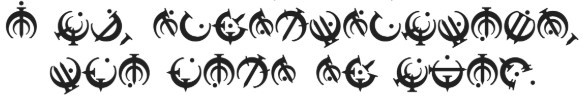

In [1]:
from PIL import Image

img = Image.open("i_am_unfortunately_stacked.jpg").convert("L")
display(img)

In [2]:
import numpy as np

width, height = img.size
pixels = np.array(img.getdata()).reshape((height, width))
pixels = pixels / 255
pixels

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [34]:
def get_line_bounds(pixels, pixel_threshold=0.5, dist_threshold=3):
    if np.max(pixels) > 1:
        pixels = pixels / 255
    
    pixel_mask = np.any(pixels < pixel_threshold, axis=1)
    edges = np.diff(pixel_mask.astype(int))
    starts = np.where(edges == 1)[0] + 1
    ends = np.where(edges == -1)[0] + 1

    # Handle cases where the text is on first of last pixel
    if pixel_mask[0]:  
        starts = np.insert(starts, 0, 0)
    if pixel_mask[-1]:
        ends = np.append(ends, len(pixel_mask))
    
    merge_mask = (starts[1:] - ends[:-1]) < dist_threshold

    bounds = []
    if np.any(merge_mask):
        i = 0
        start_idx = starts[i]
        while i < len(merge_mask):
            if merge_mask[i]:
                i += 1
            else:
                end_idx = ends[i]
                bounds.append((start_idx, end_idx))
                i += 1
                start_idx = starts[i]
        bounds.append((start_idx, ends[-1]))
    
    return np.array(bounds)
    
line_bounds = get_line_bounds(pixels)
line_bounds

array([[ 1, 48],
       [54, 94]])

In [41]:
def get_cropped_bbox(pixels, bounds, pixel_threshold=0.5):
    start, end = bounds
    line = pixels[start:end]
    pixel_indices = np.where(np.any(line < pixel_threshold, axis=0))[0]
    return (np.min(pixel_indices), start, np.max(pixel_indices), end)

get_cropped_bbox(pixels, line_bounds[0])

(np.int64(6), np.int64(1), np.int64(577), np.int64(48))

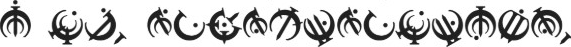

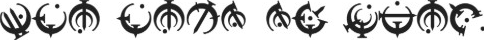

In [42]:
def crop_lines(image, bounds):
    line_images = []
    for bound in bounds:
        bbox = get_cropped_bbox(pixels, bound)
        line_images.append(image.crop(bbox))
    return line_images

for image in crop_lines(img, line_bounds):
    display(image)

In [43]:
class LineSegmenter:
    def __init__(self, pixel_threshold=0.5, dist_threshold=3):
        self.pixel_threshold = pixel_threshold
        self.dist_threshold = dist_threshold

    def get_line_bounds(self, pixels):   
        # Find edges of text lines 
        pixel_mask = np.any(pixels < self.pixel_threshold, axis=1)
        edges = np.diff(pixel_mask.astype(int))
        starts = np.where(edges == 1)[0] + 1
        ends = np.where(edges == -1)[0] + 1

        # Handle cases where the text is on first or last pixel
        if pixel_mask[0]:  
            starts = np.insert(starts, 0, 0)
        if pixel_mask[-1]:
            ends = np.append(ends, len(pixel_mask))
        
        # Merge lines that are close enough
        merge_mask = (starts[1:] - ends[:-1]) < self.dist_threshold
        bounds = []
        if np.any(merge_mask):
            i = 0
            start_idx = starts[i]
            while i < len(merge_mask):
                if merge_mask[i]:
                    i += 1
                else:
                    end_idx = ends[i]
                    bounds.append((start_idx, end_idx))
                    i += 1
                    start_idx = starts[i]
            bounds.append((start_idx, ends[-1]))
        return bounds

    def get_cropped_bbox(self, pixels, bounds):
        start, end = bounds
        line = pixels[start:end]
        pixel_indices = np.where(np.any(line < self.pixel_threshold, axis=0))[0]
        return (np.min(pixel_indices), start, np.max(pixel_indices), end)

    def crop_lines(self, image, bounds):
        line_images = []
        for bound in bounds:
            bbox = self.get_cropped_bbox(pixels, bound)
            line_images.append(image.crop(bbox))
        return line_images
    
    def segment(self, image):
        # Preprocess image
        image_grayscale = image.convert("L")
        pixels = np.array(image_grayscale.getdata()).reshape(image.size[::-1])
        pixels = pixels / 255

        line_bounds = self.get_line_bounds(pixels)
        return self.crop_lines(image, line_bounds)

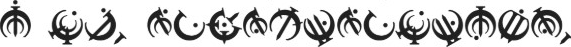

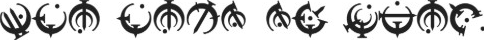

In [44]:
segmenter = LineSegmenter()
images = segmenter.segment(img)
for image in images:
    display(image)